[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/074_preceiver_intro/074_preceiver_intro.ipynb)

# PerceiverIO

En el post anterior vimos la arquitectura *Perceiver*, base del modelo más avanzado *PerceiverIO*, el cual aprenderemos a implementar en este post.

![](https://lh3.googleusercontent.com/355TNHvZGNS2yaYFD1yhlZt_JsyAQGCc8XMWf0bX0FhFK-O7HjJsBrnuOvazj3OfzBkTSZYGJ1wMHPJlYW21Fhhi-5bxYOgk9TqHMIEA0yEGmD9H5A=w1440-rw-v1)

A grandes rasgos, *PerceiverIO* es muy similar a *Perceiver*. Utiliza exactamente la misma arquitectura para la codificación y procesado de datos. La única diferencia es en la salida, ya que introduce un *decoder* que es capaz de generar *outputs* para diferentes tareas. Gracias a este desacople entre entradas/salidas y el procesado de características, la red neuronal es capaz de llevar a cabo multitud de tareas en vez de tener que recurrir a modelos específicos (CNNs, RNNs, ...) en función del tipo de datos y tarea que queramos llevar a cabo.

In [4]:
# https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
# https://github.com/esceptico/perceiver-io/blob/master/src/perceiver/attention.py

import math
import torch

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.n_embd = q_dim
        self.n_heads = n_heads
        assert self.n_embd % self.n_heads == 0
        # key, query, value projections
        self.key = torch.nn.Linear(kv_dim, self.n_embd)
        self.query = torch.nn.Linear(q_dim, self.n_embd)
        self.value = torch.nn.Linear(kv_dim, self.n_embd)
        # regularization
        self.attn_drop = torch.nn.Dropout(attn_pdrop)
        self.resid_drop = torch.nn.Dropout(resid_pdrop)
        # output projection
        self.proj = torch.nn.Linear(self.n_embd, q_dim)

    def forward(self, kv, q, mask = None): 
        B, M, C = kv.size()
        B, N, D = q.size()
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, M, hs)
        q = self.query(q).view(B, N, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, N, hs)
        v = self.value(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, M, hs)
        # attention (B, nh, N, hs) x (B, nh, hs, M) -> (B, nh, N, M)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if mask is not None:
            att = att.masked_fill(self.mask[:,:,:N,:M] == 0, float('-inf')) 
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, N, M) x (B, nh, M, hs) -> (B, nh, N, hs)
        y = y.transpose(1, 2).contiguous().view(B, N, D) # re-assemble all head outputs side by side
        return self.resid_drop(self.proj(y)) # B, N, D

class Block(torch.nn.Module):
    def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.ln1_kv = torch.nn.LayerNorm(kv_dim)
        self.ln1_q = torch.nn.LayerNorm(q_dim)
        self.ln2 = torch.nn.LayerNorm(q_dim)
        self.attn = MultiHeadAttention(kv_dim, q_dim, n_heads, attn_pdrop, resid_pdrop)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(q_dim, 4 * q_dim),
            torch.nn.GELU(),
            torch.nn.Linear(4 * q_dim, q_dim),
            torch.nn.Dropout(resid_pdrop),
        )

    def forward(self, kv, q, mask=None):
        x = q + self.attn(self.ln1_kv(kv), self.ln1_q(q), mask)
        x = x + self.mlp(self.ln2(x))
        return x

class PerceiverEncoder(torch.nn.Module):
    # ejemplo sin recurrencia para clasificación
    def __init__(self, num_latents, latent_dim, input_dim, num_blocks, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        # se podrían separar los params en función de si es cross o self ...
        super().__init__()
        self.num_blocks = num_blocks
        self.latents = torch.nn.Parameter(torch.randn(num_latents, latent_dim))
        # encode
        self.cross_attn = Block(
            kv_dim=input_dim, 
            q_dim=latent_dim, 
            n_heads=n_heads, 
            attn_pdrop=attn_pdrop, 
            resid_pdrop=resid_pdrop
        )
        # process
        self.self_attention_blocks = torch.nn.ModuleList([
            Block( # se podrían hacer bloques diferenciados para en el forward pasar solo x
                kv_dim=latent_dim,
                q_dim=latent_dim,
                n_heads=n_heads, 
                attn_pdrop=attn_pdrop, 
                resid_pdrop=resid_pdrop
            ) for _ in range(num_blocks)
        ])

    def forward(self, x, mask = None):
        B = x.size(0)
        if mask is not None:
            mask = mask[None, None, :, :] # esto no se si está bien :S
        x = self.cross_attn(
            kv=x,
            q=self.latents.repeat(B, 1, 1),
            mask=mask
        )
        for _ in range(self.num_blocks):
            for self_attn_layer in self.self_attention_blocks:
                x = self_attn_layer(x, x)
        return x

Para este primer ejemplo vamos a implementar un *decoder* para clasificación de imágenes. Este *decoder* recibirá la salida del *encoder*, que ya implementamos en el post anterior, y que usaremos como *keys* y *values*. En cuanto a las *query*, usaremos un tensor con las dimensiones a las que queramos proyectar las salidas del *encoder*, en nuestro caso al número de clases a las cuales queramos hacer la clasificación. De la misma manera que el modelo aprenderá la mejor representación para las *query* a la entrada, lo mismo hacemos a la salida.

In [9]:
# https://github.com/esceptico/perceiver-io/blob/master/src/perceiver/decoders.py

class ClassificationDecoder(torch.nn.Module):
    def __init__(self, num_classes, latent_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.task_ids = torch.nn.Parameter(torch.randn(1, num_classes))
        self.decoder = Block( 
            kv_dim=latent_dim,
            q_dim=num_classes,
            n_heads=n_heads, 
            attn_pdrop=attn_pdrop, 
            resid_pdrop=resid_pdrop
        )

    def forward(self, latents):
        b = latents.size(0)
        logits = self.decoder(
            kv=latents,
            q=self.task_ids.repeat(b, 1, 1)
        )
        return logits.squeeze(1)

In [11]:
decoder = ClassificationDecoder(10, 512)

decoder

ClassificationDecoder(
  (decoder): Block(
    (ln1_kv): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (ln1_q): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (attn): MultiHeadAttention(
      (key): Linear(in_features=512, out_features=10, bias=True)
      (query): Linear(in_features=10, out_features=10, bias=True)
      (value): Linear(in_features=512, out_features=10, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (resid_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=10, out_features=10, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): GELU()
      (2): Linear(in_features=40, out_features=10, bias=True)
      (3): Dropout(p=0.0, inplace=False)
    )
  )
)

In [14]:
output = decoder(torch.randn(32, 128, 512))

output.shape

torch.Size([32, 10])

Como puedes ver, podemos adaptar el *decoder* de manera muy sencilla para generar *outputs* de la dimensión que queramos, haciendo del *PerceiverIO* una arquitectura muy flexible. Podríamos tener diversos *decoders* para generar múltiples outputs o incluso entrenar un solo modelo con un solo *decoder* pero diferentes *query* para diferentes tareas (*multi-tasking*). Este hecho, junto a la flexibilidad a la hora de aceptar diferentes tipos de inputs que ya hereda del *Perciever* convierte a este modelo en uno de los más flexibles a día de hoy.

## Clasificación de imágenes

Vamos a ver el mismo ejemplo que vimos en el post anterior: clasificación de imágenes con el dataset CIFAR10. Esta vez, con el nuevo modelo.

In [42]:
from einops import rearrange, repeat
from math import pi, log

class FourierEncoder(torch.nn.Module):
    def __init__(self, max_freq, num_freq_bands, freq_base=2):
        super().__init__()
        self.max_freq = max_freq
        self.num_freq_bands = num_freq_bands
        self.freq_base = freq_base

    def fourier_encode(self, x):
        x = x.unsqueeze(-1)
        device, dtype, orig_x = x.device, x.dtype, x
        scales = torch.logspace(0., log(self.max_freq / 2) / log(self.freq_base), self.num_freq_bands, base = self.freq_base, device = device, dtype = dtype)
        scales = scales[(*((None,) * (len(x.shape) - 1)), ...)]
        x = x * scales * pi
        x = torch.cat([x.sin(), x.cos()], dim=-1)
        x = torch.cat((x, orig_x), dim = -1)
        return x

    def forward(self, x):
         # fourier encoding
        b, *axis, _, device = *x.shape, x.device
        axis_pos = list(map(lambda size: torch.linspace(-1., 1., steps = size, device = device), axis))
        pos = torch.stack(torch.meshgrid(*axis_pos), dim = -1)
        enc_pos = self.fourier_encode(pos)
        enc_pos = rearrange(enc_pos, '... n d -> ... (n d)')
        enc_pos = repeat(enc_pos, '... -> b ...', b = b)
        x = torch.cat((x, enc_pos), dim = -1)
        x = rearrange(x, 'b ... d -> b (...) d')
        return x

In [51]:
class PerceiverIO(torch.nn.Module):
    def __init__(self, num_classes, max_freq ,num_freq_bands, num_latents, latent_dim, input_dim, num_blocks, freq_base = 2, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        fourier_channels = (2 * ((num_freq_bands * 2) + 1))
        input_dim += fourier_channels
        self.fourier_encoder = FourierEncoder(
            max_freq=max_freq,
            num_freq_bands=num_freq_bands,
            freq_base=freq_base
        )
        self.encoder = PerceiverEncoder(
            num_latents=num_latents, 
            latent_dim=latent_dim, 
            input_dim=input_dim,
            num_blocks=num_blocks,
            n_heads=n_heads, 
            attn_pdrop=attn_pdrop, 
            resid_pdrop=resid_pdrop
        )
        self.decoder = ClassificationDecoder(
            num_classes=num_classes,
            latent_dim=latent_dim,
            n_heads=n_heads,
            attn_pdrop=attn_pdrop,
            resid_pdrop=resid_pdrop
        )

    def forward(self, x, mask = None):
        x = self.fourier_encoder(x)
        if mask is not None:
            mask = mask[None, None, :, :] # esto no se si está bien :S
        x = self.encoder(x, mask)
        return self.decoder(x)

In [52]:
perceiver = Perceiver(num_classes=10, max_freq=10, num_freq_bands=6, num_latents=256, latent_dim=512, input_dim=3, num_blocks=2)

output = perceiver(torch.randn(32, 32, 32, 3))

output.shape

torch.Size([32, 10])

In [53]:
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).float(), torch.tensor(self.labels[ix]).long()

In [58]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

batch_size = 64
num_workers = 0

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

Files already downloaded and verified
Files already downloaded and verified


(torch.Size([64, 32, 32, 3]), torch.Size([64]))

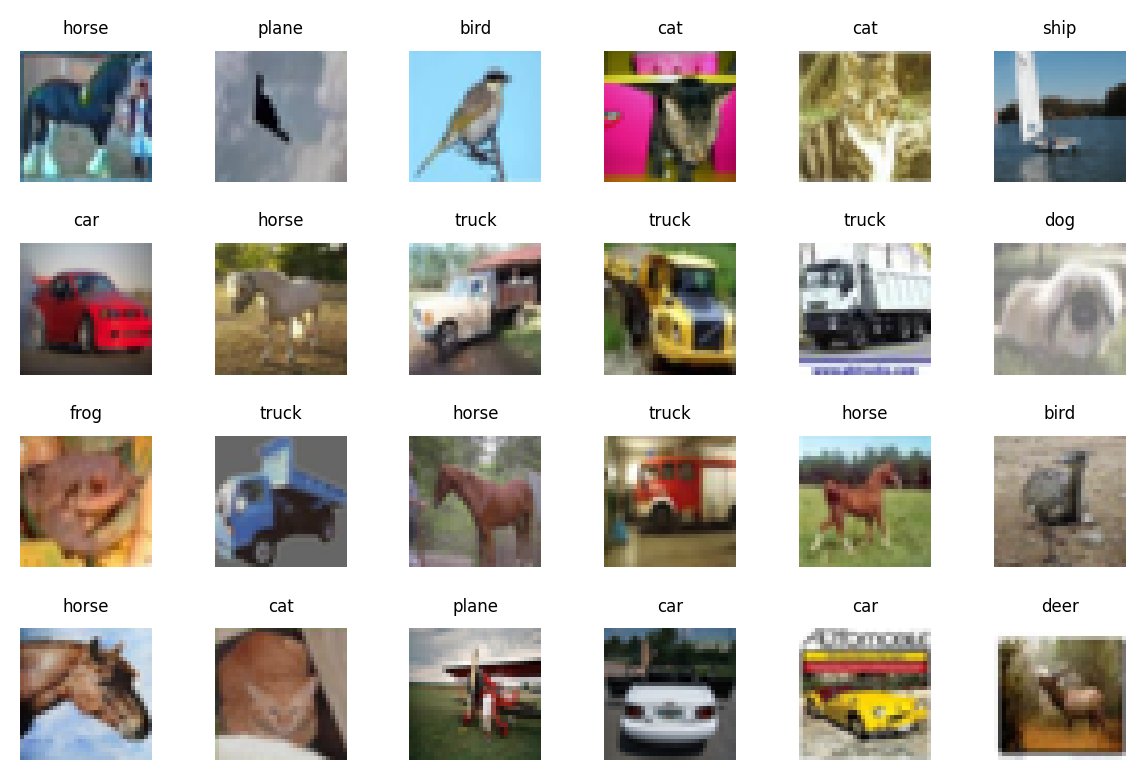

In [59]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        ax.set_title(ds['train'].classes[labels[ix].item()], fontsize=6)
        ax.axis('off')
plt.tight_layout()
plt.show()

In [60]:
from tqdm import tqdm
import torch.nn.functional as F

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda", overfit=False):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        # como cambiar el shuffle a False si overfit ?
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            if overfit: 
                break
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        if overfit:
            bar = tqdm(dl['train'])
        else:
            bar = tqdm(dl['test'])
        with torch.inference_mode():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
                if overfit: 
                    break
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

In [61]:
import pandas as pd

def plot_hist(hist):
    fig = plt.figure(figsize=(10, 3), dpi=100)
    df = pd.DataFrame(hist)
    ax = plt.subplot(1, 2, 1)
    df[['loss', 'test_loss']].plot(ax=ax)
    ax.grid(True)
    ax = plt.subplot(1, 2, 2)
    df[['acc', 'test_acc']].plot(ax=ax)
    ax.grid(True)
    plt.show()

In [76]:
model = PerceiverIO(num_classes=10, max_freq=10, num_freq_bands=6, num_latents=256, latent_dim=512, input_dim=3, num_blocks=2)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=64, shuffle=False, num_workers=0)
}

In [77]:
hist = train(model, dl, optimizer, epochs=50, overfit=False)

testing... loss 1.9216 acc 0.2906: 100%|██████████| 157/157 [00:05<00:00, 27.30it/s]


Epoch 1/50 loss 2.0996 acc 0.2065 test_loss 1.9216 test_acc 0.2906


testing... loss 1.7187 acc 0.3832: 100%|██████████| 157/157 [00:05<00:00, 28.45it/s]


Epoch 2/50 loss 1.8338 acc 0.3283 test_loss 1.7187 test_acc 0.3832


testing... loss 1.6229 acc 0.4182: 100%|██████████| 157/157 [00:05<00:00, 27.29it/s]


Epoch 3/50 loss 1.6774 acc 0.3963 test_loss 1.6229 test_acc 0.4182


testing... loss 1.5667 acc 0.4399: 100%|██████████| 157/157 [00:05<00:00, 27.24it/s]


Epoch 4/50 loss 1.5754 acc 0.4360 test_loss 1.5667 test_acc 0.4399


testing... loss 1.4622 acc 0.4799: 100%|██████████| 157/157 [00:05<00:00, 27.18it/s]


Epoch 5/50 loss 1.5076 acc 0.4585 test_loss 1.4622 test_acc 0.4799


testing... loss 1.4217 acc 0.4881: 100%|██████████| 157/157 [00:05<00:00, 27.32it/s]


Epoch 6/50 loss 1.4438 acc 0.4794 test_loss 1.4217 test_acc 0.4881


testing... loss 1.3736 acc 0.5044: 100%|██████████| 157/157 [00:05<00:00, 27.23it/s]


Epoch 7/50 loss 1.3913 acc 0.5005 test_loss 1.3736 test_acc 0.5044


testing... loss 1.3810 acc 0.5055: 100%|██████████| 157/157 [00:05<00:00, 27.38it/s]


Epoch 8/50 loss 1.3446 acc 0.5176 test_loss 1.3810 test_acc 0.5055


testing... loss 1.3592 acc 0.5194: 100%|██████████| 157/157 [00:05<00:00, 27.32it/s]


Epoch 9/50 loss 1.3036 acc 0.5300 test_loss 1.3592 test_acc 0.5194


testing... loss 1.2931 acc 0.5354: 100%|██████████| 157/157 [00:05<00:00, 27.13it/s]


Epoch 10/50 loss 1.2636 acc 0.5470 test_loss 1.2931 test_acc 0.5354


testing... loss 1.2588 acc 0.5509: 100%|██████████| 157/157 [00:05<00:00, 27.01it/s]


Epoch 11/50 loss 1.2266 acc 0.5598 test_loss 1.2588 test_acc 0.5509


training... loss 1.1813 acc 0.5763:  19%|█▊        | 145/782 [00:14<01:06,  9.61it/s]

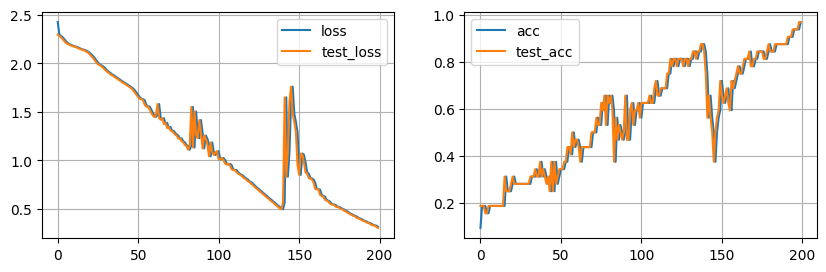

In [75]:
plot_hist(hist)

In [ ]:
imgs, labels = next(iter(dl['train']))

model.eval()
with torch.inference_mode():
    logits = model(imgs.cuda())
    preds = torch.argmax(logits, axis=1).cpu()

preds.shape

In [ ]:
fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        gt = ds['test'].classes[labels[ix].item()]
        pr = ds['test'].classes[preds[ix].item()]
        ax.set_title(f'{pr}/{gt}', fontsize=6, color='green' if pr == gt else 'red')
        ax.axis('off')
plt.tight_layout()
plt.show()

## Resumen

En este post hemos implementado nuestro primer modelo basado en la arquitectura *PercieverIO*. Para ello, hemos reutilizado el código implementado en el post anterior para el *Perceiver* y añadido la parte del *decoder*, capaz de generar *outputs* de dimensiones determinadas que podemos controlar. De esta manera, nuestro modelo desacopla totalmente las entradas/salidas de la parte de extracción y procesado de características convirtiendo al *PerceiverIO* en una red neuronal muy flexible capaz de trabajar con imágenes, texto, audio, video e incluso combinaciones de los mismos a la vez que puede usarse para diferentes tareas como la clasificación, generación de texto, detección de objetos en imágenes, etc. En los siguientes posts exploraremos más en detalle estas características.

## Recursos

- [Paper](https://arxiv.org/pdf/2107.14795.pdf)
- [Blog](https://deepmind.com/blog/article/building-architectures-that-can-handle-the-worlds-data) DeepMind.
- Videos:
    1. [Gaurav Chauhan](https://www.youtube.com/watch?v=AS1Sh-KuNzs&t=163s)
    2. [The AI Epiphany](https://www.youtube.com/watch?v=WJWBq4NZfvY&feature=youtu.be)
- Código:
    1. Implementación original de [DeepMind](https://github.com/deepmind/deepmind-research/tree/master/perceiver) (JAX)
    2. Pytorch: [lucidrains](https://github.com/lucidrains/perceiver-pytorch), [esceptico](https://github.com/esceptico/perceiver-io)